## Code for the Figures Used in the Final Report

__________________________________________________________________________________________

##### Team module with clean datasets

In [1]:
import awesome_puppies as ap

##### Packages used for the figures

In [2]:
import pandas as pd
import numpy as np
import datetime

%matplotlib inline

__________________________________________________________________________________________

### Regional Broadcast Markets

#### Code for the map showing the Regional Broadcast Markets is saved as a Python file because the Jupyter Notebook file for the map was too large to upload to GitHub.

__________________________________________________________________________________________

### Number of Ads by Ad Beneficiary

#### Create dataframe

In [3]:
# Set up data with value counts for number ads for each candidate

candidate_ads = (
    ap.ads_df.beneficiary.value_counts()
    .rename_axis("candidate_name")
    .to_frame("num_ads")
    .loc[["Trump", "Clinton"]]
)

# Create dataframe with value counts to be used for bar chart

df_candidate_ads = pd.DataFrame(
    candidate_ads, columns=["num_ads"], index=["Clinton", "Trump"]
)

df_candidate_ads.reset_index(inplace=True)


#### Create bar chart

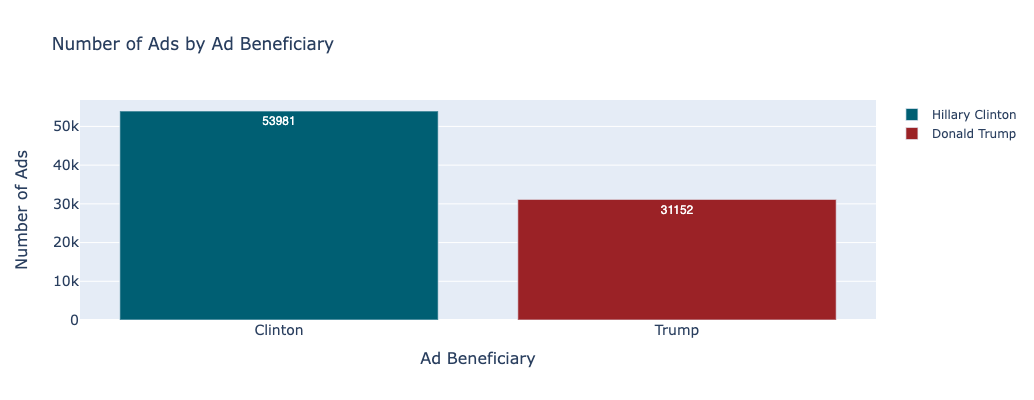

In [4]:
from plotly import graph_objs as go

df_clinton = df_candidate_ads.iloc[np.where(df_candidate_ads["index"] == "Clinton")]
df_trump = df_candidate_ads.iloc[np.where(df_candidate_ads["index"] == "Trump")]


trace_clinton = go.Bar(
    x=df_clinton["index"],
    y=df_clinton["num_ads"],
    marker=dict(color="#005F73"),
    text=df_clinton["num_ads"],
    name="Hillary Clinton",
    textfont=dict(family="Helvetica"),
)

trace_trump = go.Bar(
    x=df_trump["index"],
    y=df_trump["num_ads"],
    marker=dict(color="#9B2226"),
    text=df_trump["num_ads"],
    name="Donald Trump",
    textfont=dict(family="Helvetica"),
)


data = [trace_clinton, trace_trump]


layout = dict(
    title="Number of Ads by Ad Beneficiary",
    showlegend=True,
    barmode="group",
    paper_bgcolor="#ffffff",  # background color
    # plot_bgcolor="#ffffff",  # plot background color
    xaxis=dict(
        title="Ad Beneficiary",
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis=dict(
        title="Number of Ads",
        titlefont_size=16,
        tickfont_size=14,
    ),
    width=800,
    height=400,
)


fig = go.Figure(data=data, layout=layout)

fig.show()


__________________________________________________________________________________________

### Number of ads for Ad Beneficiary by Region

#### Create dataframe

In [5]:
# Find total number of ads per candidate
total_ads_cands = (
    ap.ads_df.groupby("beneficiary")
    .size()
    .to_frame("total_ads")
    .reset_index()
    .set_index("beneficiary")
)

# Break out each region into its own row
regs_names = ap.ads_df.drop("region_id", axis=1).join(
    ap.ads_df["region_id"].str.replace("_", " ").str.title().rename("region")
)

# Find number of ads by candidate for each region
df_regs_cands = (
    regs_names.groupby("beneficiary")["region"]
    .value_counts()
    .to_frame("num_ads")
    .reset_index()
    .set_index("beneficiary")
)

# Sort the regions and candidatews by most ads
sorted_regs_cands = df_regs_cands.sort_values("num_ads", ascending=False)

# Merge total number of ads for each candidate with number of ads for each candidate by region
df_regs_cands_merged = sorted_regs_cands.merge(
    total_ads_cands, how="inner", left_index=True, right_index=True
)

# Find the percent of ads in the candidate for each region
df_regs_cands_merged["perc_ads"] = (
    df_regs_cands_merged.num_ads / df_regs_cands_merged.total_ads
)

# Sort by highest percentage
regs_cands_df = df_regs_cands_merged.sort_values(
    "perc_ads", ascending=False
).reset_index()


#### Create bar chart

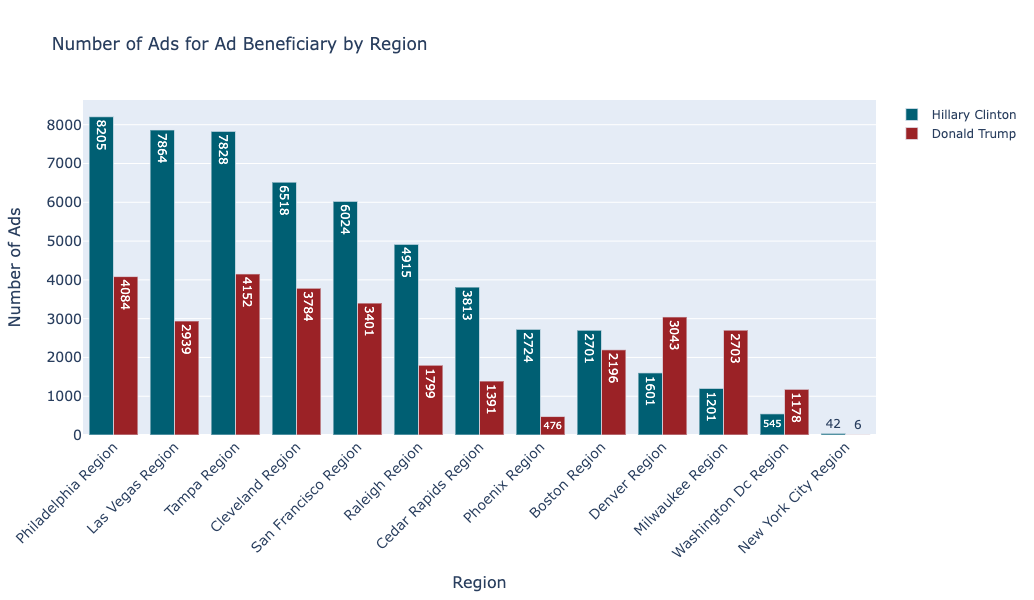

In [6]:
import plotly.graph_objects as go

clinton_df = regs_cands_df.loc[regs_cands_df["beneficiary"] == "Clinton"]
trump_df = regs_cands_df.loc[regs_cands_df["beneficiary"] == "Trump"]


fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=clinton_df["region"],
        y=clinton_df["num_ads"],
        name="Hillary Clinton",
        marker_color="#005F73",
        text=clinton_df["num_ads"],
    )
)
fig.add_trace(
    go.Bar(
        x=trump_df["region"],
        y=trump_df["num_ads"],
        name="Donald Trump",
        marker_color="#9B2226",
        text=trump_df["num_ads"],
    )
)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(
    barmode="group",
    xaxis_tickangle=-45,
    width=800,
    height=600,
    title="Number of Ads for Ad Beneficiary by Region",
    xaxis=dict(
        title="Region",
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis=dict(
        title="Number of Ads",
        titlefont_size=16,
        tickfont_size=14,
    ),
)
fig.show()


__________________________________________________________________________________________

### Most Ads vs. Most Votes by Ad Beneficiary and Region

#### Create dataframe

In [7]:
# get all the votes by region
votes = ap.votes_by_region()

# make a new col called 'most_votes'
# this finds the max value between the democrat, republican,
# and other cols but returns the col name (not the value itself)
votes["most_votes"] = votes[["democrat", "republican", "other"]].idxmax(axis=1)

# join the votes df and the ad_counts_by_region_and_beneficiary df on 'location' column
final = pd.merge(votes, ap.ad_counts_by_region_and_beneficiary(), on=["region_id"])

# make a new col called 'most_ads'
# this finds the max value between the Clinton and Trump
# cols but returns col name (not the value itself)
final["most_ads"] = final[["Clinton", "Trump"]].idxmax(axis=1)

# change the value in column from candidate name to
# party name ('democrat' or 'republican') using map
final["most_ads"] = final["most_ads"].map(
    {"Clinton": "democrat", "Trump": "republican"}
)

# 'congruent' means party with most votes == party with most ads
# if most_votes matches most_ads, then congruent = True, else False
final["congruent"] = np.where(final["most_votes"] == final["most_ads"], True, False)

# output final df
cols = ["most_votes", "most_ads", "congruent"]
cong_df = final[cols].reset_index()


In [8]:
# Change formatting for regions
ads_votes_df = cong_df.drop("region_id", axis=1).join(
    cong_df["region_id"].str.replace("_", " ").str.title().rename("region")
)


#### Create table

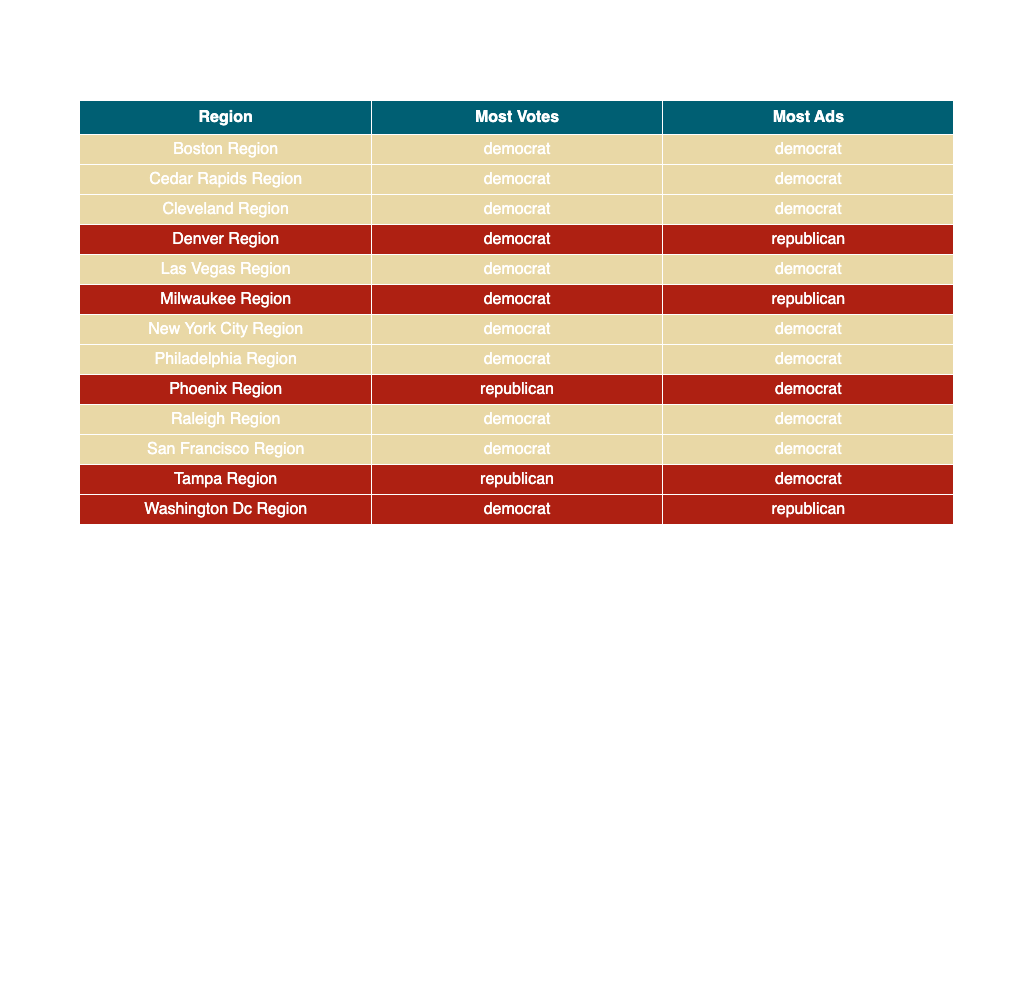

In [9]:
import plotly.graph_objects as go
import plotly.figure_factory as ff


region = ads_votes_df["region"]
votes = ads_votes_df["most_votes"]
ads = ads_votes_df["most_ads"]


colors = ["#AE2012" if x != y else "#E9D8A6" for x, y in zip(votes, ads)]


fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["<b>Region", "<b>Most Votes", "<b>Most Ads"],
                fill_color="#005F73",
            ),
            cells=dict(values=[region, votes, ads], fill_color=[colors], height=30),
        )
    ]
)

fig.update_layout(
    title="Candidate Ads vs. Votes",
    font=dict(family="Helvetica", size=16, color="#ffffff"),
    width=800,
    height=1000,
)


fig.show()


__________________________________________________________________________________________

### Top 10 Subjects for Ad Beneficiaries

#### Create dataframe

In [10]:
subjs_df = ap.ads_df.drop("subjects", axis=1).join(
    ap.ads_df["subjects"]
    .str.split(", ", expand=True)
    .stack()
    .reset_index(level=1, drop=True)
    .rename("subjects")
)

# Group data by subjects and regions

df_subjs_cands = (
    subjs_df.groupby("beneficiary")["subjects"]
    .value_counts()
    .to_frame("num_ads")
    .reset_index()
)

sorted_subjs_cands = df_subjs_cands.sort_values("num_ads", ascending=False)

# Get top 10 subjects for each region
top10_subjs_cands = (
    sorted_subjs_cands.groupby("beneficiary").head(10).reset_index(drop=True)
)


#### Create Sankey diagram

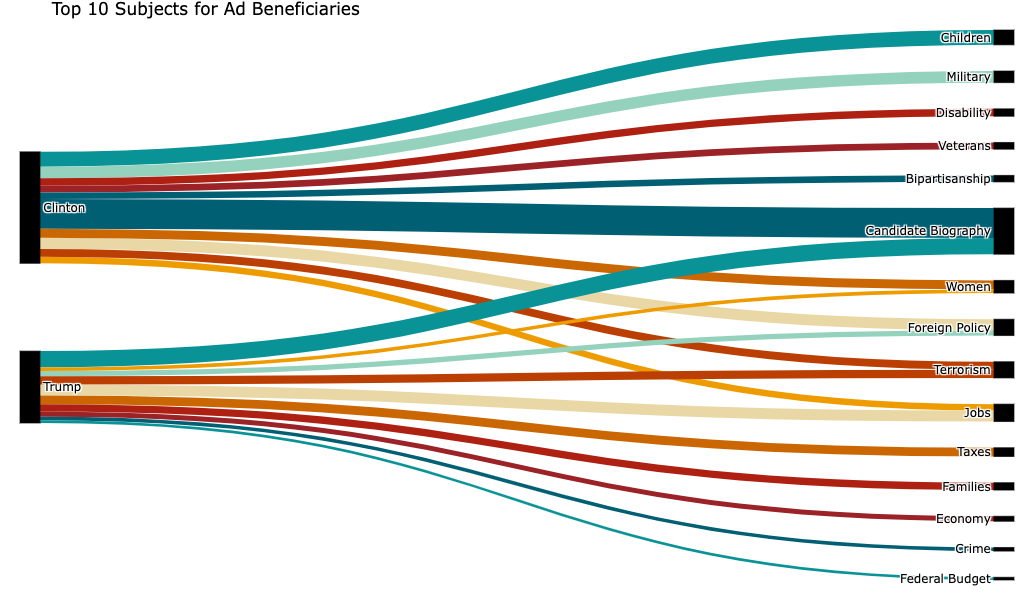

In [11]:
# Create top 10 list for subjects and remove duplicates
subjs_nodes = top10_subjs_cands["subjects"].drop_duplicates().tolist()

# Create list of candidates (just Trump for this one) and remove duplicates
benefs_nodes = top10_subjs_cands["beneficiary"].drop_duplicates().tolist()

# Create a list for all nodes (use this to give an id to each node)
all_nodes = subjs_nodes + benefs_nodes


# use for colors
# use size (len) of dataframe to determine how many times colors are looped through

n = len(all_nodes)
n2 = len(top10_subjs_cands["subjects"])


# Create a dataframe with all the node ids
df1 = pd.DataFrame(all_nodes, columns=["node"])
df1 = df1.reset_index()


# Join dataframe with node ids to original dataframe
df2 = pd.merge(
    pd.merge(top10_subjs_cands, df1, how="inner", left_on="subjects", right_on="node"),
    df1,
    how="inner",
    left_on="beneficiary",
    right_on="node",
    suffixes=("_subject", "_beneficiary"),
)


# Information for creating diagram:
# Nodes are the vertical rectangles in diagram reprenting start and end
# Links are the lines connecting nodes in diagram
# Links have three main attributes:
# 1. the "origin" (index of the start node)
# 2. the "destination" (index of the end node)
# 3. the "value" (thickness of the line/band connecting nodes)
# Additional attributes available to specify for links (ie color, etc.)
data = go.Sankey(
    node=dict(
        pad=1000,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=["black"] * n,
    ),
    link=dict(
        source=df2["index_beneficiary"],
        target=df2["index_subject"],
        value=df2["num_ads"],
        color=[
            "#005F73",
            "#0A9396",
            "#94D2BD",
            "#E9D8A6",
            "#EE9B00",
            "#CA6702",
            "#BB3E03",
            "#AE2012",
            "#9B2226",
        ]
        * n2,
    ),
)
data = [data]

layout = dict(
    title="Top 10 Subjects for Ad Beneficiaries",
    font=dict(size=12, color="black"),
    margin=dict(l=20, r=20, t=30, b=20),
    hovermode=False,  # remove hover info
    autosize=False,
    width=650,
    height=600,
)


fig = go.Figure(data=data, layout=layout)


fig


__________________________________________________________________________________________

### Percent of Ads by Message Tone by Ad Beneficiary

#### Create dataframe

In [12]:
# Find total number of ads per region
total_ads_cands = (
    ap.ads_df.groupby("beneficiary")
    .size()
    .to_frame("total_ads")
    .reset_index()
    .set_index("beneficiary")
)

# Find number of ads by message type for each candidate
df_cands_msgs = (
    ap.ads_df.groupby("beneficiary")["message"]
    .value_counts()
    .to_frame("num_ads")
    .reset_index()
    .set_index("beneficiary")
)

# Sort the candidates and message types by most ads
sorted_cands_msgs = df_cands_msgs.sort_values("num_ads", ascending=False)

# Merge total number of ads for each candidate with number of ads for each message type
df_cands_msgs_merged = sorted_cands_msgs.merge(
    total_ads_cands, how="inner", left_index=True, right_index=True
)

# Find the percent of ads with message type for each candidate
df_cands_msgs_merged["perc_ads"] = (
    round(df_cands_msgs_merged.num_ads / df_cands_msgs_merged.total_ads, 2) * 100
)

# Sort by highest percentage
sorted_cands_messages = df_cands_msgs_merged.sort_values("perc_ads", ascending=False)

# Message types for clinton
df_clinton_msgs = sorted_cands_messages.loc["Clinton"]

# Message types for trump
df_trump_msgs = sorted_cands_messages.loc["Trump"]


#### Create bar chart

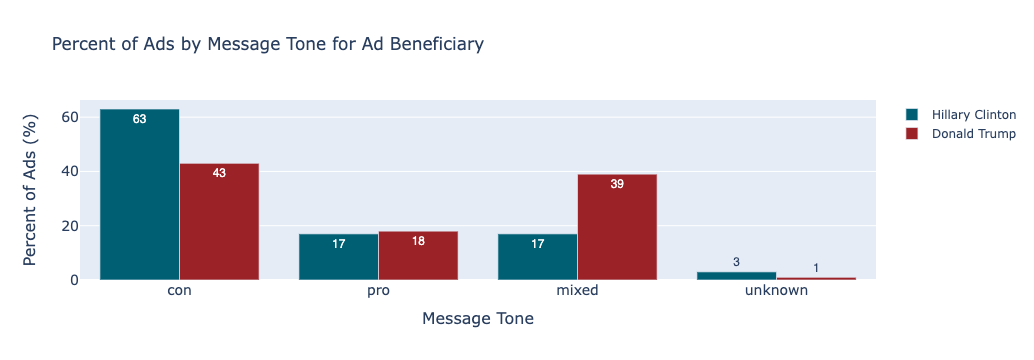

In [13]:
import plotly.graph_objects as go

trace_clinton = go.Bar(
    x=df_clinton_msgs["message"],
    y=df_clinton_msgs["perc_ads"],
    marker=dict(color="#005F73"),
    text=df_clinton_msgs["perc_ads"],
    name="Hillary Clinton",
    textfont=dict(family="Helvetica"),
)

trace_trump = go.Bar(
    x=df_trump_msgs["message"],
    y=df_trump_msgs["perc_ads"],
    marker=dict(color="#9B2226"),
    text=df_trump_msgs["perc_ads"],
    name="Donald Trump",
    textfont=dict(family="Helvetica"),
)

data = [trace_clinton, trace_trump]


layout = dict(
    title="Percent of Ads by Message Tone for Ad Beneficiary",
    showlegend=True,
    barmode="group",
    paper_bgcolor="#ffffff",  # background color
    #plot_bgcolor="#ffffff",  # plot background color
    xaxis=dict(
        title="Message Tone",
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis=dict(
        title="Percent of Ads (%)",
        titlefont_size=16,
        tickfont_size=14,
    ),
)


fig = go.Figure(data=data, layout=layout)

fig


__________________________________________________________________________________________

### Message Tone by Region

#### Create dataframe

In [14]:
# Break out each region into its own row
regs_names = ap.ads_df.drop("region_id", axis=1).join(
    ap.ads_df["region_id"].str.replace("_", " ").str.title().rename("region")
)

# Find total number of ads per region
total_ads_regs_msgs = (
    regs_names.groupby("region")
    .size()
    .to_frame("total_ads")
    .reset_index()
    .set_index("region")
)

# Find number of ads by message type for each candidate
df_regs_msgs = (
    regs_names.groupby("region")["message"]
    .value_counts()
    .to_frame("num_ads")
    .reset_index()
    .set_index("region")
)

# Sort the candidates and message types by most ads
sorted_regs_msgs = df_regs_msgs.sort_values("num_ads", ascending=False)

# Merge total number of ads for each candidate with number of ads for each message type
df_regs_msgs_merged = sorted_regs_msgs.merge(
    total_ads_regs_msgs, how="inner", left_index=True, right_index=True
)

# Find the percent of ads with message type for each candidate
df_regs_msgs_merged["perc_ads"] = (
    round(df_regs_msgs_merged.num_ads / df_regs_msgs_merged.total_ads, 2) * 100
)

# Sort by highest percentage
sorted_regs_messages = df_regs_msgs_merged.sort_values(
    "perc_ads", ascending=False
).reset_index()


#### Create heat map

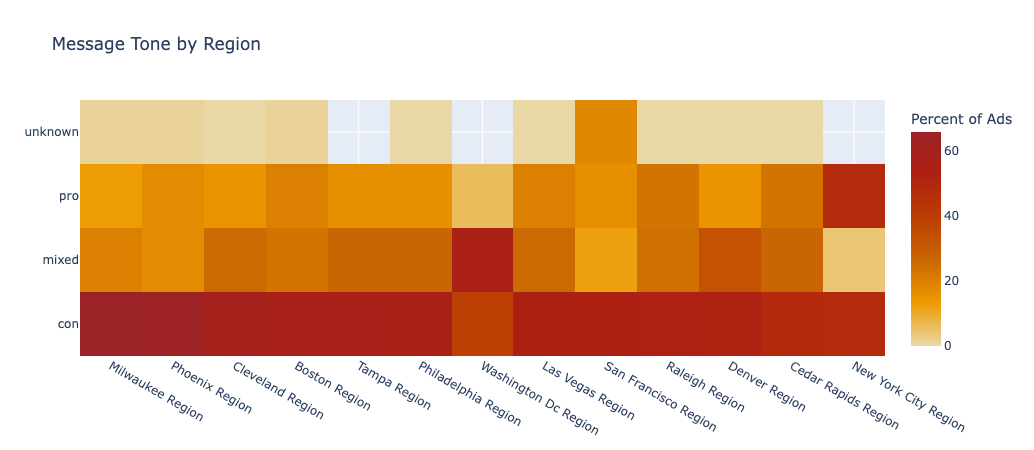

In [15]:
import plotly.graph_objects as go

fig = go.Figure(
    data=go.Heatmap(
        z=sorted_regs_messages["perc_ads"],
        x=sorted_regs_messages["region"],
        y=sorted_regs_messages["message"],
        hoverongaps=False,
        colorscale=[
            [0.0, "rgb(233, 216, 166)"],
            [0.20, "rgb(238, 155, 0)"],
            [0.40, "rgb(202, 103, 2)"],
            [0.60, "rgb(187, 62, 3)"],
            [0.80, "rgb(174, 32, 18)"],
            [1.0, "rgb(155, 34, 38)"],
        ],
        colorbar={"title": "Percent of Ads"},
    )
)


fig.update_layout(
    showlegend=True,
    autosize=False,
    title="Message Tone by Region",
)


fig.show()


__________________________________________________________________________________________

### Ads Aired by Hour of the Day

#### Create bar chart

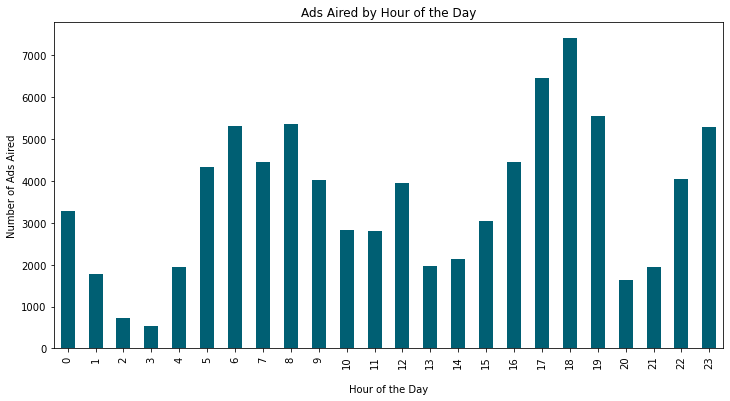

In [16]:
import matplotlib.pyplot as plt

ap.ads_df["air_time_hour"] = pd.to_datetime(ap.ads_df.air_time).dt.hour

ax = ap.groupby_agg(
    ap.ads_df, groupby_list=["air_time_hour"], func="size", fill_value=0
).plot(kind="bar", figsize=(12, 6), color="#005F73")

plt.title("Ads Aired by Hour of the Day")
plt.ylabel("Number of Ads Aired")
plt.xlabel("\nHour of the Day")

plt.show()


__________________________________________________________________________________________

### Percent of Ads Aired by Day of the Week

#### Create dataframe

In [17]:
days_of_week_by_cand = (
    ap.ads_df.groupby(["beneficiary", "day_of_week"])
    .size()
    .unstack()
    .reindex(
        columns=[
            "Sunday",
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
        ]
    )
    .T
)

days_of_week_by_cand_norm = days_of_week_by_cand.transform(lambda x: x / x.sum())


#### Create bar chart

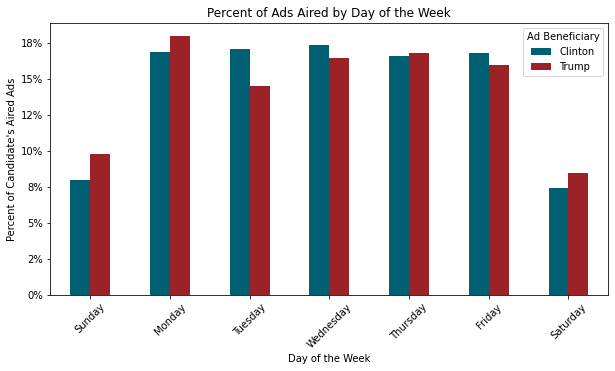

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

ax = days_of_week_by_cand_norm.transform(lambda x: x * 100).plot(
    kind="bar", figsize=(10, 5), color={"Clinton": "#005F73", "Trump": "#9B2226"}
)

plt.title("Percent of Ads Aired by Day of the Week")
plt.ylabel("Percent of Candidate's Aired Ads")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.legend(title="Ad Beneficiary")

fmt = "{x:,.0f}%"
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)


__________________________________________________________________________________________

### Total Weekly Ads Aired by Each Beneficiary

#### Create dataframe

In [19]:
cand_week_counts_regions = (
    ap.ads_df.groupby(["beneficiary", "region_id"])
    .resample("W", on="start_time")
    .size()
    .unstack(level=1)
)


clinton_week_reg = cand_week_counts_regions.loc["Clinton"]
clinton_week_reg["Clinton_Average"] = clinton_week_reg.mean(axis=1)

trump_week_reg = cand_week_counts_regions.loc["Trump"]
trump_week_reg["Trump_Average"] = trump_week_reg.mean(axis=1)

clinton_week_reg.fillna(value=0, inplace=True)
trump_week_reg.fillna(value=0, inplace=True)


#### Create line plot

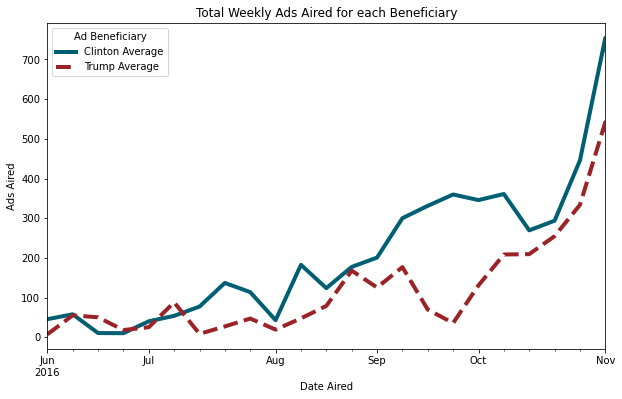

In [20]:
import matplotlib.pyplot as plt

## Clinton Average
ax = clinton_week_reg["Clinton_Average"].plot(kind="line", figsize=(10, 6))
ax.lines[-1].set_color("#005F73")
ax.lines[-1].set_linewidth(4)
ax.lines[-1].set_linestyle("solid")

# Trump Average
trump_week_reg["Trump_Average"].plot(kind="line", ax=ax)
ax.lines[-1].set_color("#9B2226")
ax.lines[-1].set_linewidth(4)
ax.lines[-1].set_linestyle("dashed")

# Title and Labels
plt.title("Total Weekly Ads Aired for each Beneficiary")
plt.legend(
    ["Clinton Average", "Trump Average"], loc="upper left", title="Ad Beneficiary"
)
# ax.get_legend().remove()
plt.ylabel("Ads Aired")
plt.xlabel("Date Aired")

# Limit x-axis range
plt.xlim([datetime.date(2016, 6, 1), datetime.date(2016, 11, 1)])

plt.show()



__________________________________________________________________________________________

### Weekly Ads Aired for each Candidate per Region

#### Create dataframe

In [21]:
plot = (
    cand_week_counts_regions.drop(["new_york_city_region"], axis=1)
    .fillna(0)
    .unstack()
    .T
)

plot_regions = list(set([i[0] for i in plot.index]))


#### Create line plots

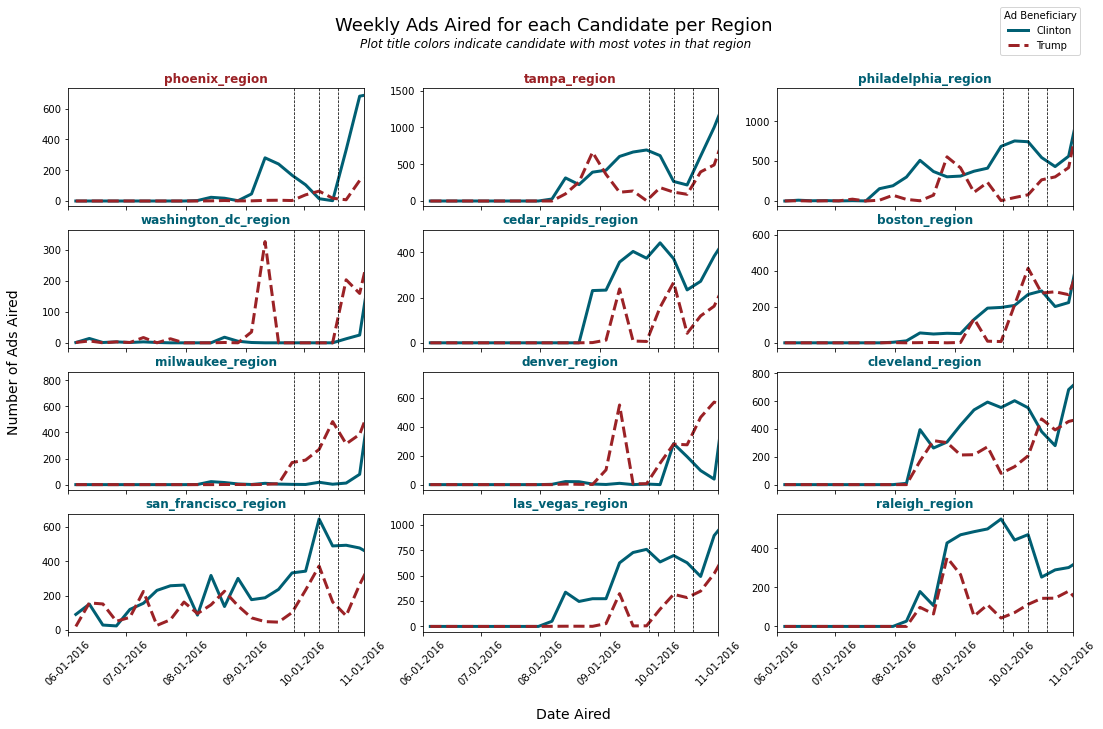

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

myFmt = mdates.DateFormatter("%m-%d-%Y")

fig, ax = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(18, 10))
rows = range(4)
cols = range(3)

# Region index
r = 0

# Colors for each region based on candidate voted for
reg_colors = {
    "phoenix_region": "#9B2226",
    "tampa_region": "#9B2226",
    "philadelphia_region": "#005F73",
    "washington_dc_region": "#005F73",
    "cedar_rapids_region": "#005F73",
    "boston_region": "#005F73",
    "milwaukee_region": "#005F73",
    "denver_region": "#005F73",
    "cleveland_region": "#005F73",
    "san_francisco_region": "#005F73",
    "las_vegas_region": "#005F73",
    "raleigh_region": "#005F73",
}
regions = list(reg_colors.keys())

# Plot Clinton and Trump for each region
for row in rows:
    for col in cols:
        region = regions[r]
        data = plot.loc[region]
        ax[row][col].plot(
            data.index, data.Clinton, "#005F73", linewidth=3, linestyle="solid"
        )
        ax[row][col].plot(
            data.index, data.Trump, "#9B2226", linewidth=3, linestyle="dashed"
        )

        # Label this subplot
        ax[row][col].set_title(
            region, fontdict={"fontweight": "bold"}, color=reg_colors[region]
        )

        # X Axis Formatting
        ax[row][col].xaxis.set_major_formatter(myFmt)
        plt.sca(ax[row][col])
        plt.xticks(rotation=45)

        # Limit x-axis range
        plt.xlim([datetime.date(2016, 6, 1), datetime.date(2016, 11, 1)])

        # Adding vertical lines at dates of debates
        plt.axvline(
            datetime.datetime(2016, 9, 26),
            color="black",
            linestyle="dashed",
            linewidth=0.75,
        )
        plt.axvline(
            datetime.datetime(2016, 10, 9),
            color="black",
            linestyle="dashed",
            linewidth=0.75,
        )
        plt.axvline(
            datetime.datetime(2016, 10, 19),
            color="black",
            linestyle="dashed",
            linewidth=0.75,
        )

        r += 1

# Axis Labels & Legend
fig.text(
    0.078, 0.5, "Number of Ads Aired", va="center", rotation="vertical", fontsize=14
)
fig.text(0.486, 0.0, "Date Aired", va="bottom", rotation="horizontal", fontsize=14)
fig.legend(
    [ax[0][0].lines[0], ax[0][0].lines[1]],
    ["Clinton", "Trump"],
    title="Ad Beneficiary",
    bbox_to_anchor=(0.91, 1.0),
)

fig.suptitle("Weekly Ads Aired for each Candidate per Region", fontsize=18)
fig.text(
    0.35,
    0.95,
    "Plot title colors indicate candidate with most votes in that region",
    va="top",
    fontsize=12,
    fontstyle="italic",
)


pass


__________________________________________________________________________________________